# Pre-processamento de todas as imagens de pragas

In [1]:
# Imports de avisos
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulacao de dados e calculos matematicos
import os
import pandas as pd
import numpy as np
import math, re, time
import pathlib
import shutil
from pathlib import Path
import glob

# Import para manipulação das imagens
import matplotlib.pyplot as plt
from matplotlib import pyplot
import IPython.display as display
from PIL import Image
from skimage.transform import resize
import cv2
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

## Carregando dataset de imagens de Pragras

In [2]:
# Importando o arquivo de imagens de pragas
#from google.colab import files
#uploaded = files.upload()

In [3]:
#!unzip ../imagens/imagens.zip ../imagens/

In [4]:
# Importando o dataset do diretorio de treino
data_dir = pathlib.Path('../imagens')

# Verificando quantas imagens tem nos diretórios
image_count = len(list(data_dir.glob('*/*.*')))
print('Quantidade de Imagens: ', image_count)

# Verificando todas as classes de pragas (menos a pasta .DS_Store)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if (item.name != ".DS_Store") & (item.name != ".ipynb_checkpoints")])

# Print das categorias de pragas
print('Classes: ', CLASS_NAMES)

# Visualizando o tamanho de cada classe
fnames = []
for classes in CLASS_NAMES:
    flower_folder = os.path.join(data_dir, classes)
    file_names    = os.listdir(flower_folder)
    full_path     = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('Tamanho de cada classe de pragas:', [len(f) for f in fnames])

Quantidade de Imagens:  251
Classes:  ['lagarta' 'negativas' 'percevejo_marrom' 'percevejo_pequeno'
 'percevejo_verde']
Tamanho de cada classe de pragas: [60, 100, 34, 31, 26]


## Visualização dos Dados

In [5]:
lagarta            = list(data_dir.glob('lagarta/*.png'))
percevejo_marrom   = list(data_dir.glob('percevejo_marrom/*.png'))
percevejo_pequeno  = list(data_dir.glob('percevejo_pequeno/*.png'))
percevejo_verde    = list(data_dir.glob('percevejo_verde/*.png'))

(792, 202)


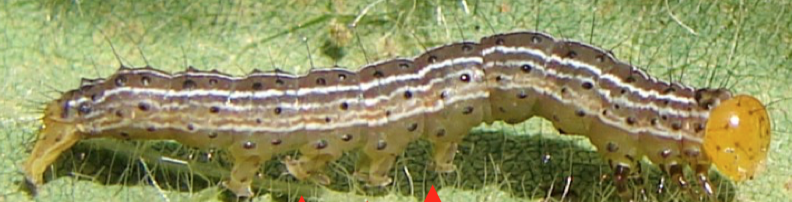

(590, 332)


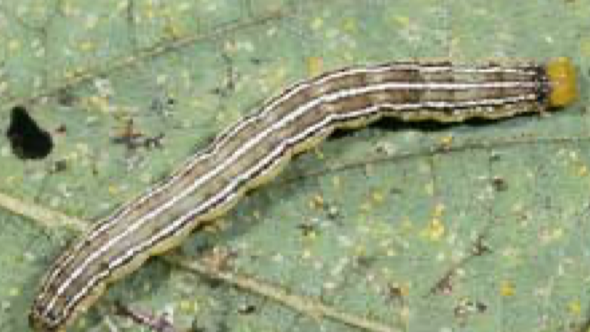

(342, 406)


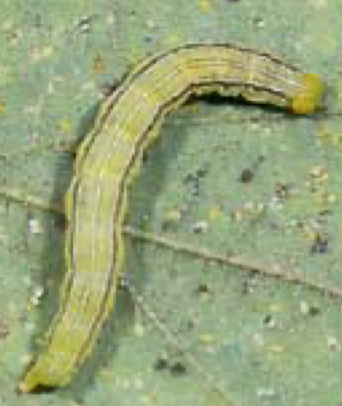

In [6]:
# Visualizando fotos de lagarta
for image_path in lagarta[:3]:
    print(Image.open(str(image_path)).size)
    display.display(Image.open(str(image_path)))

(792, 630)


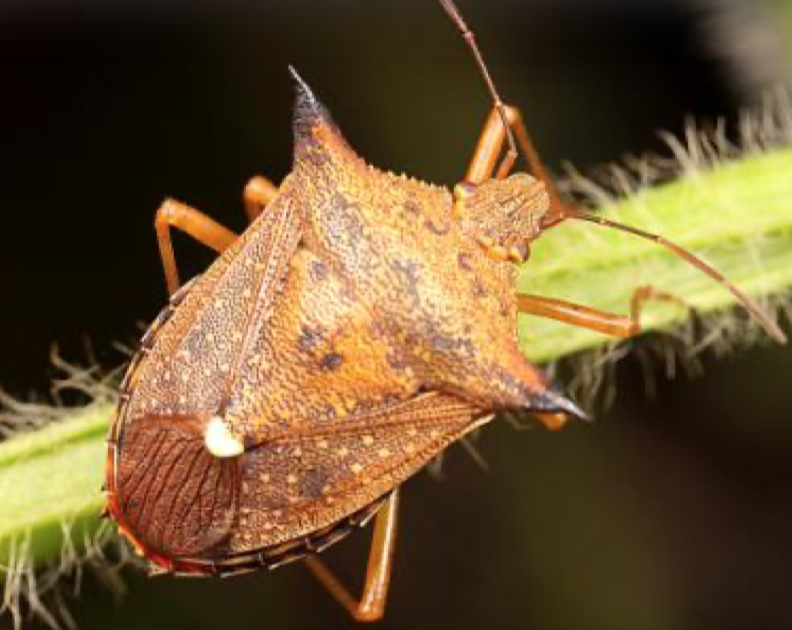

(554, 558)


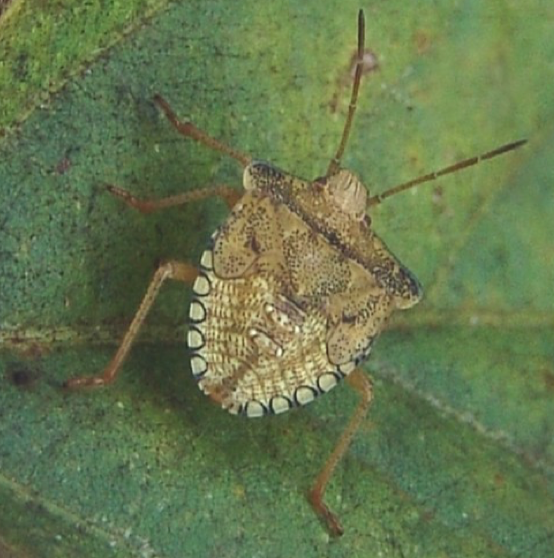

(564, 416)


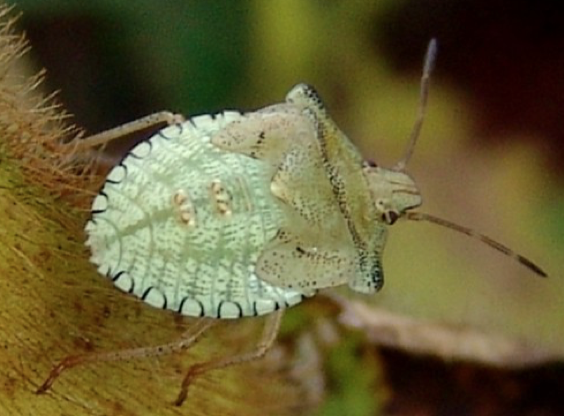

In [7]:
# Visualizando fotos de percevejo marrom
for image_path in percevejo_marrom[:3]:
    print(Image.open(str(image_path)).size)
    display.display(Image.open(str(image_path)))

## Remover Background

## Dataset Augmentation (Geração de Imagens Sintéticas)

In [8]:
# Número de imagens sintéticas desejadas
NUM_IMAGENS_SINTETICAS = 120 

# Cria imagens sintéticas para aumentar o volume de dados de treino (não fazemos isso com dados de validação/teste)

print('\nGeração de imagens sintéticas para treinamento! Aguarde...\n')

# Loop pelas imagens de cada classe
for item in CLASS_NAMES:
    
    # Estamos criando diretório temporário aqui porque o excluiremos posteriormente.
    # Criamos um diretório base
    aug_dir = '../imagens/temp/'
    os.mkdir(aug_dir)
    
    # Criamos um diretório dentro do diretório base para armazenar imagens da mesma classe
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Escolhe a classe
    img_class = item

    # Listamos todas as imagens no diretório
    img_list = os.listdir('../imagens/'+img_class)

    # Copiamos imagens do diretório de treino para a classe no loop, para o img_dir
    for fname in img_list:
            
            # Diretório fonte da imagem
            src = os.path.join('../imagens/'+img_class, fname)
            
            # Diretório destino da imagem
            dst = os.path.join(img_dir, fname)

            try:
                # Copia a imagem da fonte para o destino
                shutil.copyfile(src, dst)
            except:
                continue


    # Apontamos para o diretório contendo as imagens que foram copiadas
    path = aug_dir
    save_path = '../imagens/' + img_class

    # Criamos um gerador de imagens 
    datagen = ImageDataGenerator(rotation_range     = 10,
                                 width_shift_range  = 0.1,
                                 height_shift_range = 0.1,
                                 zoom_range         = 0.1,
                                 horizontal_flip    = True,
                                 fill_mode          = 'nearest')

    # Tamanho do batch
    batch_size = 10

    aug_datagen = datagen.flow_from_directory(path,
                                              save_to_dir = save_path,
                                              save_format = 'png',
                                              target_size = (512, 512),
                                              batch_size = batch_size)
    
    
    # Geramos as imagens aumentadas e adicionamos às pastas de treinamento
    num_files = len(os.listdir(img_dir))
    
    # Aqui criamos uma quantidade semelhante de imagens para cada classe
    num_batches = int(np.ceil((NUM_IMAGENS_SINTETICAS - num_files) / batch_size))

    # Executa o gerador e cria imagens aumentadas
    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)
        
    # Exclui o diretório temporário com os arquivos de imagem brutos
    shutil.rmtree(aug_dir)
    
print('\nOs dados foram criados com sucesso!')


Geração de imagens sintéticas para treinamento! Aguarde...

Found 58 images belonging to 1 classes.
Found 98 images belonging to 1 classes.
Found 32 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 25 images belonging to 1 classes.

Os dados foram criados com sucesso!


## Redimensionar Imagens Originais

In [ ]:
original_folder = '../imagens/lagarta'
output_folder   = '../imagens/lagarta/resized'
dir_path        = Path(output_folder)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_path.exists():
    shutil.rmtree(dir_path, ignore_errors=True)
    os.mkdir(dir_path)
else:
    os.mkdir(dir_path)
    
i = 0
for img in glob.glob(original_folder + "/*.png"):
    image = cv2.imread(img)
    imgResized = cv2.resize(image, (512, 512), interpolation = cv2.INTER_LINEAR) 
    cv2.imwrite(output_folder + "/image%04i.png" %i, imgResized)
    i += 1


In [ ]:
original_folder = '../imagens/percevejo_marrom'
output_folder   = '../imagens/percevejo_marrom/resized'
dir_path        = Path(output_folder)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_path.exists():
    shutil.rmtree(dir_path, ignore_errors=True)
    os.mkdir(dir_path)
else:
    os.mkdir(dir_path)
    
i = 0
for img in glob.glob(original_folder + "/*.png"):
    image = cv2.imread(img)
    imgResized = cv2.resize(image, (512, 512), interpolation = cv2.INTER_LINEAR) 
    cv2.imwrite(output_folder + "/image%04i.png" %i, imgResized)
    i += 1


In [ ]:
original_folder = '../imagens/percevejo_pequeno'
output_folder   = '../imagens/percevejo_pequeno/resized'
dir_path        = Path(output_folder)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_path.exists():
    shutil.rmtree(dir_path, ignore_errors=True)
    os.mkdir(dir_path)
else:
    os.mkdir(dir_path)
    
i = 0
for img in glob.glob(original_folder + "/*.png"):
    image = cv2.imread(img)
    imgResized = cv2.resize(image, (512, 512), interpolation = cv2.INTER_LINEAR) 
    cv2.imwrite(output_folder + "/image%04i.png" %i, imgResized)
    i += 1


In [ ]:
original_folder = '../imagens/percevejo_verde'
output_folder   = '../imagens/percevejo_verde/resized'
dir_path        = Path(output_folder)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_path.exists():
    shutil.rmtree(dir_path, ignore_errors=True)
    os.mkdir(dir_path)
else:
    os.mkdir(dir_path)
    
i = 0
for img in glob.glob(original_folder + "/*.png"):
    image = cv2.imread(img)
    imgResized = cv2.resize(image, (512, 512), interpolation = cv2.INTER_LINEAR) 
    cv2.imwrite(output_folder + "/image%04i.png" %i, imgResized)
    i += 1


In [ ]:
original_folder = '../imagens/negativas'
output_folder   = '../imagens/negativas/resized'
dir_path        = Path(output_folder)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_path.exists():
    shutil.rmtree(dir_path, ignore_errors=True)
    os.mkdir(dir_path)
else:
    os.mkdir(dir_path)
    
i = 0
for img in glob.glob(original_folder + "/*.png"):
    image = cv2.imread(img)
    imgResized = cv2.resize(image, (512, 512), interpolation = cv2.INTER_LINEAR) 
    cv2.imwrite(output_folder + "/image%04i.png" %i, imgResized)
    i += 1


## Criando arquivo ZIP final

In [ ]:
dir_path = Path('../imagens/zip')

# Verificamos se o diretório já existe e se não existir, criamos
if dir_path.exists():
    shutil.rmtree(dir_path, ignore_errors=True)
else:
    os.mkdir(dir_path)

In [ ]:
# Zipando imagens das lagartas
!zip -r ../imagens/zip/lagarta.zip ../imagens/lagarta/resized

In [ ]:
# Zipando imagens das lagartas
!zip -r ../imagens/zip/percevejo_marrom.zip ../imagens/percevejo_marrom/resized

In [ ]:
# Zipando imagens das lagartas
!zip -r ../imagens/zip/percevejo_pequeno.zip ../imagens/percevejo_pequeno/resized

In [ ]:
# Zipando imagens das lagartas
!zip -r ../imagens/zip/percevejo_verde.zip ../imagens/percevejo_verde/resized